<a href="https://colab.research.google.com/github/taschoebli/ml_coding_challenge_1schnitzel_2bratwurst/blob/main/Satellite_Classification_Code_ML_by_Luzi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  **EuroSAT - Satellite Image Classification**
Training Data is Level 1C whereas Testing Data is Level 2A

**Code by**: Seraphin Sattler, https://github.com/Sesatt/EuroSAT-satellite-image-classification

**Adjusted by**: Luzi Schöb

**Network Architecture**: Convolutional Neural Network

## **1. Setup of the Notebook Environment**




In [1]:
import os
import glob
import numpy as np
!pip -q install rasterio
import rasterio as rio
from rasterio.plot import reshape_as_image, reshape_as_raster
import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 61.7 MB/s eta 0:00:00


## **2. Data Gathering**

### **2.1 Training Data**

In [2]:
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate

--2024-05-04 14:22:21--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  12.7MB/s    in 2m 32s  

2024-05-04 14:24:54 (13.0 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [3]:
!unzip -q "/content/EuroSATallBands.zip"

In [4]:
# change this to your eurosat path
eurosat_dir = "/content/ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
print(str(len(samples)) + " trainingset samples with 10 different classes")

27000 trainingset samples with 10 different classes


### **2. Testset Data**

In [ ]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/coding_challenge/testset.zip" #"/content/drive/MyDrive/Colab Notebooks/coding_challenge/Data/testset.zip"
testset_dir = "/content/testset"
test_samples = glob.glob(os.path.join(testset_dir, "*.npy"))
print(str(len(test_samples)) + " testset samples")

## **3. Data Assessment**


In [ ]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

Now let's visualize a sample as we did for Eurosat

### **3.1 Visualize Training Data**

In [ ]:
#load image
sample_idx = 25000
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]

with rio.open(sample, "r") as d:
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

#reshape to (64x64x13) to match the convention of matplotlib
img = reshape_as_image(np.array(img))

#normalize image across bands
normalized_img = normalize_for_display(img)

fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")

        axs[i,j].axis(False)
        band_idx += 1

plt.tight_layout()
plt.show()

### **3.2 Visualize Test Data**

In [ ]:
test_idx = 10
test_img = np.load(test_samples[test_idx])
normalized_img = normalize_for_display(test_img)

fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]

for i in range(4):
    for j in range(4):
        if band_idx < 12:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")

        axs[i,j].axis(False)
        band_idx += 1

plt.tight_layout()
plt.show()

### **3.3 Export All Test Data as Image**

In [ ]:
'''for index, path in enumerate(test_samples[:500]): #only 5 test_samples[:5]
  filename = os.path.splitext(os.path.basename(path))[0]
  #print(path)
  #print(filename)
  #print(index)
  img= np.load(path)
  normalized_img = normalize_for_display(img)
  rgb_img = normalized_img[:, :, [3,2,1]]
  #rgb_img_255 = rgb_img * 255 # scale from 0...1 float to 0...255
  #print(rgb_img)
  #print(rgb_img_255)
  #image = Image.fromarray(rgb_img_255, mode="RGB")
  #image.save(f'/content/drive/MyDrive/Colab Notebooks/coding_challenge/images/{filename}.jpg')
  #cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/coding_challenge/images/{filename}.png', rgb_img)

  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow(rgb_img)
  ax.set_title(f"{filename}")
  ax.axis(False)
  plt.tight_layout()

  plt.show()'''

### **3.4 Export All Training Data as Image**

In [11]:
'''for index in enumerate(samples[:5]): #only 5 test_samples[:5]
  with rio.open(sample, "r") as d:
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

  #reshape to (64x64x13) to match the convention of matplotlib
  img = reshape_as_image(np.array(img))

  #normalize image across bands
  normalized_img = normalize_for_display(img)

  rgb_img = normalized_img[:, :, [3,2,1]]
  #rgb_img_255 = rgb_img * 255 # scale from 0...1 float to 0...255
  #print(rgb_img)
  #print(rgb_img_255)
  #image = Image.fromarray(rgb_img_255, mode="RGB")
  #image.save(f'/content/drive/MyDrive/Colab Notebooks/coding_challenge/images/{filename}.jpg')
  #cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/coding_challenge/images/{filename}.png', rgb_img)

  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow(rgb_img)
  ax.set_title(f"{filename}")
  ax.axis(False)
  plt.tight_layout()

  plt.show()'''

'for index in enumerate(samples[:5]): #only 5 test_samples[:5]\n  with rio.open(sample, "r") as d:\n    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])\n\n  #reshape to (64x64x13) to match the convention of matplotlib\n  img = reshape_as_image(np.array(img))\n\n  #normalize image across bands\n  normalized_img = normalize_for_display(img)\n\n  rgb_img = normalized_img[:, :, [3,2,1]]\n  #rgb_img_255 = rgb_img * 255 # scale from 0...1 float to 0...255\n  #print(rgb_img)\n  #print(rgb_img_255)\n  #image = Image.fromarray(rgb_img_255, mode="RGB")\n  #image.save(f\'/content/drive/MyDrive/Colab Notebooks/coding_challenge/images/{filename}.jpg\')\n  #cv2.imwrite(f\'/content/drive/MyDrive/Colab Notebooks/coding_challenge/images/{filename}.png\', rgb_img)\n\n  fig, ax = plt.subplots(1, figsize=(5,5))\n  ax.imshow(rgb_img)\n  ax.set_title(f"{filename}")\n  ax.axis(False)\n  plt.tight_layout()\n\n  plt.show()'

### **3.5 Findings and Modifications**

Looking closely at the above displayed picture, there are two main points that require some adjustment:

1. B9 from Training set is not included in test set --> remove for training
2. B12 in the training set corresponds to B8A in the test set. Therefore the last band in the training set has to be moved to the 9th position, whereby the current bands B8A to B11 are shifted one position up.

## **4. Data Preprocessing and Augmentation**

### **4.1 Setup the Environment**

In [12]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

In [13]:
import os, urllib, io
from datetime import datetime
import numpy as np
from numpy.random import default_rng
from scipy.ndimage import gaussian_filter
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [14]:
# create the data sub-directory
data_directory = './ConvNet/data_eurosat'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './ConvNet/models_eurosat'
if not os.path.exists(models_directory): os.makedirs(models_directory)

In [15]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

In [16]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [110]:
CUDA_LAUNCH_BLOCKING=1

### **4.2 Data Preprocessing**

Two main steps for data preprocessing:
1. load all samples in the right order and add NDVI index
2. Standardize data across images but within each band

In [111]:
def data_preparation(sample_paths):
  """Input: list of paths where images are saved.
  Images are loaded, bands are put into the right order and NDVI index is added.
  Output: Images as array of shape (NxHxWxC) + corresponding array of labels"""

  data_list = []
  data_array = np.empty((0, 64, 64, 16), dtype = np.float16)
  labels = np.array([])

  #loop through sample paths to load all samples
  for i in range(len(sample_paths)):
    sample = sample_paths[i]
    label = sample.split('/')[-1].split('_')[0]
    label_no = classes.index(label)
    labels = np.append(labels,label_no)

    with rio.open(sample, "r") as d:
      #read all bands but B10 (index: 10) (which is not in test data)
      #move band 13 to position 9 (Band 8A is at last position (13) for training data but at position 9 in test data)
      #B01->1
      #B02->2
      #B03->3
      #B04->4
      #B05->5
      #B06->6
      #B07->7
      #B08->8
      #B08A->13
      #B09->9
      #B11->11
      #B12->12
      #order of training data is now adjusted to order of test data!
      img = d.read([1,2,3,4,5,6,7,8,13,9,11,12])

    #reshape to 64x64x16
    img = np.moveaxis(img,0,2)

    #add NDMI https://www.usgs.gov/landsat-missions/normalized-difference-moisture-index (B8A-B11)/(B8A+B11)
    img = np.append(img, np.array((img[:,:,8]-img[:,:,10])/(img[:,:,8]+img[:,:,10])).reshape(64,64,1), axis = 2)

    #add ND_custom(blue) index as additional input channel (B8-B2)/(B8+B2)
    img = np.append(img, np.array((img[:,:,7]-img[:,:,1])/(img[:,:,7]+img[:,:,1])).reshape(64,64,1), axis = 2)

    #add ND_custom(green) index as additional input channel (B8-B3)/(B8+B3)
    img = np.append(img, np.array((img[:,:,7]-img[:,:,2])/(img[:,:,7]+img[:,:,2])).reshape(64,64,1), axis = 2)

    #add NDVI index as additional input channel (B8-B4)/(B8+B4)
    img = np.append(img, np.array((img[:,:,7]-img[:,:,3])/(img[:,:,7]+img[:,:,3])).reshape(64,64,1), axis = 2)

    data_list.append(img)

    #for every 1000 samples append samples to array --> needed to save memory
    if (i+1) % 1000 == 0:
      data_array = np.append(data_array, np.array(data_list, dtype = np.float16), axis = 0)
      data_list = []

  return data_array, labels

In [112]:
def normalize_data(images):
    """Input: array with images of shape (NxHxWxC).
    Normalizes / Standardizes data across images but within each band.
    Output: Array with normalized images of shape (NxHxWxC)"""

    #set nan to 0
    images[np.isnan(images)] = 0

    #compute mean and standard deviation. Float16 to save memory
    band_mean = np.mean(images, axis = (0,1,2), dtype = np.float64).astype('float16')
    band_std = np.std(images, axis = (0,1,2), dtype = np.float64).astype('float16')

    #standardize data across images within each band
    for i in range(len(band_mean)):
      images[:,:,:,i]=(images[:,:,:,i]-band_mean[i])/band_std[i]

    return images

In [113]:
#Note: divide by 0 error occurs because of NDVI index creation. NAN is later set to 0.
data, labels = data_preparation(samples)

<ipython-input-111-cad3fc6fcb58>:42: RuntimeWarning: invalid value encountered in divide
  img = np.append(img, np.array((img[:,:,7]-img[:,:,1])/(img[:,:,7]+img[:,:,1])).reshape(64,64,1), axis = 2)
<ipython-input-111-cad3fc6fcb58>:48: RuntimeWarning: invalid value encountered in divide
  img = np.append(img, np.array((img[:,:,7]-img[:,:,3])/(img[:,:,7]+img[:,:,3])).reshape(64,64,1), axis = 2)


In [114]:
data = normalize_data(data)

In [115]:
print("data shape: ", data.shape)
print("labels shape: ", labels.shape)

data shape:  (27000, 64, 64, 16)
labels shape:  (27000,)


### **4.3 Data Augmentation**
Two main data augmentation techniques:
1. Randomly augment 30% of data by rotating 90°, flipping upside-down or flipping left-right
2. Randomly augment 30% of data by eliminating pixel patches of size 12x12

In [116]:
def data_augmentation(data, labels, augmentation_perc = 0.2):
  """Input: data: 4D array with images of shape (NxHxWxC); labels: 1D array of labels.
  Randomly augments 30% (augmentation_perc) of data by rotating 90°, flipping upside-down, or flipping left-to-right
  Randomly augments 30% (augmentation_perc) of data by eliminating pixel patches of size 12x12
  Output: 4D array of augmented data (NxHxWxC) + 1D array of labels
  """

  N = len(labels)
  adj_data = []

  #create random indices (without replacement) to define which images to use for augmentation
  augmentation_size = round(augmentation_perc*N)
  rotate_idx = np.random.choice(N, size = augmentation_size, replace = False)
  eliminate_idx = np.random.choice(N, size = augmentation_size, replace = False)

  #data augmentation 1: do randomly either of: flip upside-down, flip left-right, rotate by 90°
  for i in range(N):
    img = data[i]
    label_no = labels[i]
    if i in rotate_idx:
      rand = np.random.randint(3, size = 1)
      if rand == 0:
        img_adj1 = np.flipud(img)
      elif rand == 1:
        img_adj1 = np.fliplr(img)
      elif rand == 2:
        img_adj1 = np.rot90(img, 1, [0,1])
      labels = np.append(labels,label_no)
      adj_data.append(img_adj1)

    #data augmentation 2: eliminate patch of size 12x12 from image
    if i in eliminate_idx:
      q=64
      P=q*q
      ps=12
      IDX = np.random.randint(P)
      x0, y0 = np.unravel_index(IDX,(q,q))
      x, y, x1, y1 = x0, y0, x0 + ps, y0 + ps
      img[x:x1, y:y1,:] = 0.0
      img_adj3 = img
      labels = np.append(labels, label_no)
      adj_data.append(img_adj3)

    #append images to array every 1000 images to save memory
    if (i+1) % 1000 == 0:
      data = np.append(data, np.array(adj_data, dtype = np.float16), axis = 0)
      adj_data = []

  # unique, counts = np.unique(labels, return_counts=True)

  # size = min(counts)
  # adj_indices = []
  # for i in range(len(classes)):
  #     old_indices = [idx for idx, value in enumerate(labels) if value == i]
  #     new_sample = np.random.choice(old_indices, size, replace = False)
  #     adj_indices.extend(new_sample)


  return data, labels

In [117]:
data, labels = data_augmentation(data, labels)

In [118]:
print("data shape: ", data.shape)
print("labels shape: ", labels.shape)

data shape:  (37800, 64, 64, 16)
labels shape:  (37800,)


### **4.4 Creation of own training and test set**
We created an own training and test set (80/20) to potentially detect overfitting. Additionally, be put our samples into random order.

In [119]:
def randomize(data,labels):
  """Input: 4D Array with images of shape (NxHxWxC); 1D Array of Labels.
  Brings data into random order.
  Output: 4D Array with randomly ordered images of shape (NxHxWxC), 1D Array of randomly ordered labels."""

  N = len(labels)
  rand_idx = np.random.choice(N, size = N, replace = False)
  data = data[rand_idx]
  labels = labels[rand_idx]
  return data, labels

In [120]:
def train_test(data, labels, test_size_perc = 0.3):
  """Input: 4D Array with images of shape (NxHxWxC); 1D Array of Labels.
  Divides data into training and our own set of evaluation data to potentially identify overfitting.
  Output: 4D Pytorch Tensor with training images of shape (NxHxWxC), 1D Pytorch Tensor of training labels,
          4D Pytorch Tensor with test images of shape (NxHxWxC), 1D Pytorch Tensor of test labels"""

  data, labels = randomize(data, labels)

  test_size = int(test_size_perc*len(data))
  testset_idx = np.random.choice(len(data), size = test_size, replace = False)

  input_test = np.moveaxis(data[testset_idx], 3,1)
  target_test = labels[testset_idx]

  input_train = np.moveaxis(np.delete(data, testset_idx, axis = 0), 3, 1)
  target_train = np.delete(labels, testset_idx, axis = 0)

  return torch.from_numpy(input_train), torch.from_numpy(target_train), torch.from_numpy(input_test), torch.from_numpy(target_test)

In [121]:
train_data, train_labels, test_data, test_labels = train_test(data, labels)

In [122]:
print("Number of train samples: ", train_data.shape[0])
print("Number of test samples: ", test_data.shape[0])

Number of train samples:  26460
Number of test samples:  11340


## **5. Neural Network Implementation**

**Model architecture**:

* CNN with three layers (32, 64, 128)
* Kernel size: 5x5 (padding: 2)
* Max pooling after each layer

* Fully connected NN with three layers (2048, 2048, 10)
* Activation function: ReLu (last layer: Softmax)


In [136]:
# implement the Eurosat network architecture
class EurosatNet(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(EurosatNet, self).__init__()

        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=3)

        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)

        # define max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify convolution layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=3)

        # define max-pooling layer 2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify fc layer 1 - in 128 * 8 * 8, out 2048
        self.linear1 = nn.Linear(128 * 8 * 8, 2048, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity

        # specify fc layer 2 - in 2048, out 2048
        self.linear2 = nn.Linear(2048, 2048, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 2048, out 10
        self.linear3 = nn.Linear(2048, 10) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

    # define network forward pass
    def forward(self, images):

        # high-level feature learning via convolutional layers

        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))

        # define conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))

        # define conv layer 3 forward pass
        x = self.pool3(self.relu3(self.conv3(x)))

        # feature flattening

        # reshape image pixels
        x = x.view(-1, 128*8*8)

        # combination of feature learning via non-linear layers

        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))

        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))

        # return forward pass result
        return x

## **6. Neural Network Training**
* Loss: negative log-likelihood
* Optimizer: SGD
* Number of parameters: 21,518,474
* Learning rate: 0.001
* Epochs: 200
* Batch size: 64

### **6.1 Preparing Network training**

In [137]:
#initialize EurosatNet model
model = EurosatNet()

In [138]:
# device = 'cpu'

In [139]:
#push the initialized EurosatNet model to the computing device that is enabled
model = model.to(device)

In [140]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()

# print the number of model paramters
print('[LOG] Number of to be trained EurosatNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained EurosatNet model parameters: 21523178.


In [141]:
#define loss function and push it to enabled device
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

In [142]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

In [143]:
# specify the training parameters
num_epochs = 50 #200 # number of training epochs
mini_batch_size = 64 # size of the mini-batches

In [144]:
# transform training data to pytorch dataset
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)

In [145]:
# transform test data to pytorch dataset
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

In [146]:
# specifiy and instantiate PyTorch data loader that feeds the image tensors to our neural network
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=True)

In [147]:
#define function to display accracy after each epoch during network training
def get_accuracy(output, labels):
  """Input: Tensor with Output/Predictions, True labels
    Calculates classification accuracy for given output
    Output: float: accuracy"""

  _, predicted = torch.max(output.data, 1)
  total = labels.size(0)
  correct = (predicted == labels).sum().item()
  accuracy = correct / total
  return accuracy

### **6.2 Running the Network training**

We train our model and print the training and test loss, as well as training and test accuracy after each epoch.

In [148]:
# init collection of training epoch losses
train_epoch_losses = []
test_epoch_losses = []
train_epoch_accuracies = []
test_epoch_accuracies = []

# set the model in training mode
model.train()

# train the model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []
    test_mini_batch_losses = []
    train_mini_batch_accuracy = []
    test_mini_batch_accuracy = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):

        #push batch on gpu
        labels=labels.to(device, dtype = torch.int64)
        images = images.to(device, dtype = torch.float32)


        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        # determine classification loss and accuracy
        loss = nll_loss(output, labels)
        accuracy = get_accuracy(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
        train_mini_batch_accuracy.append(accuracy)

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.round(np.mean(train_mini_batch_losses),4)
    train_epoch_accuracy = np.round(np.mean(train_mini_batch_accuracy),4)

    #do the same as above for our own test set
    with torch.no_grad():
      for i, (images, labels) in enumerate(test_dataloader):
        labels=labels.to(device, dtype = torch.int64)
        images = images.to(device, dtype = torch.float32)
        output = model(images)
        loss = nll_loss(output, labels)
        accuracy = get_accuracy(output, labels)
        test_mini_batch_losses.append(loss.data.item())
        test_mini_batch_accuracy.append(accuracy)
      test_epoch_loss = np.round(np.mean(test_mini_batch_losses),4)
      test_epoch_accuracy = np.round(np.mean(test_mini_batch_accuracy),4)

    # print epoch loss and accuracy of training and test set
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {} eval-loss: {} train-acc: {} test-acc: {} '.format(str(now), str(epoch), str(train_epoch_loss), str(test_epoch_loss), str(train_epoch_accuracy), str(test_epoch_accuracy)))

    # save model to local directory
    model_name = 'eurosat_model_epoch_{}.pth'.format(str(epoch))
    info_dict = {
    'epoch' : epoch,
    'net_state' : model.state_dict(),
    'optimizer_state' : optimizer.state_dict()}
    torch.save(info_dict, os.path.join("./ConvNet/models_eurosat", model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(test_epoch_loss)

    train_epoch_accuracies.append(train_epoch_accuracy)
    test_epoch_accuracies.append(test_epoch_accuracy)

[LOG 20240504-15:42:25] epoch: 0 train-loss: 2.2765 eval-loss: 2.1838 train-acc: 0.2017 test-acc: 0.1094 
[LOG 20240504-15:42:36] epoch: 1 train-loss: 2.0051 eval-loss: 1.8505 train-acc: 0.2417 test-acc: 0.3622 
[LOG 20240504-15:42:46] epoch: 2 train-loss: 1.5722 eval-loss: 1.3008 train-acc: 0.4204 test-acc: 0.507 
[LOG 20240504-15:42:56] epoch: 3 train-loss: 1.1838 eval-loss: 1.113 train-acc: 0.5512 test-acc: 0.5639 
[LOG 20240504-15:43:06] epoch: 4 train-loss: 1.0445 eval-loss: 1.0218 train-acc: 0.5962 test-acc: 0.607 
[LOG 20240504-15:43:16] epoch: 5 train-loss: 0.9493 eval-loss: 0.9724 train-acc: 0.6431 test-acc: 0.6406 
[LOG 20240504-15:43:27] epoch: 6 train-loss: 0.8484 eval-loss: 0.8552 train-acc: 0.6846 test-acc: 0.6853 
[LOG 20240504-15:43:37] epoch: 7 train-loss: 0.7684 eval-loss: 0.7435 train-acc: 0.7178 test-acc: 0.7235 
[LOG 20240504-15:43:47] epoch: 8 train-loss: 0.6926 eval-loss: 0.6642 train-acc: 0.7515 test-acc: 0.7677 
[LOG 20240504-15:43:57] epoch: 9 train-loss: 0.61

**Plot Training Epochs vs Classification Error**

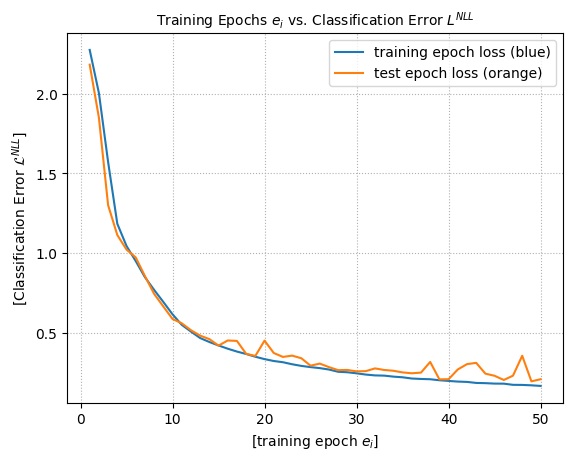

In [149]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='training epoch loss (blue)')
ax.plot(np.array(range(1, len(test_epoch_losses)+1)), test_epoch_losses, label='test epoch loss (orange)')


# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

**Plot Training Epochs vs Classification Accuracy**

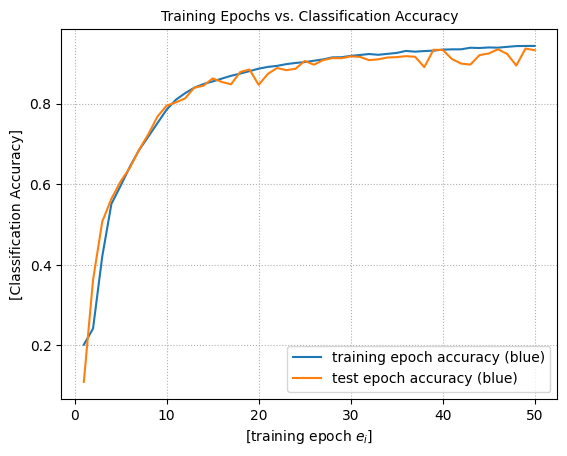

In [150]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_accuracies)+1)), train_epoch_accuracies, label='training epoch accuracy (blue)')
ax.plot(np.array(range(1, len(test_epoch_accuracies)+1)), test_epoch_accuracies, label='test epoch accuracy (blue)')


# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Accuracy]", fontsize=10)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs vs. Classification Accuracy', fontsize=10);

## **7. Neural Network Model Evaluation**

### **7.1 Load best model**

Load best model and push it to enabled device (in evaluation mode).

In [151]:
# best model is model with lowest test epoch loss (given that we see no significant overfitting before that in the above chart)

#define best model
best_model_name = '/content/ConvNet/models_eurosat/eurosat_model_epoch_{}.pth'.format(test_epoch_losses.index(min(test_epoch_losses)))
manual_model_name = '/content/ConvNet/models_eurosat/eurosat_model_epoch_{}.pth'.format(50)
# init pre-trained model class
model = EurosatNet()
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

best_model_name

'/content/ConvNet/models_eurosat/eurosat_model_epoch_48.pth'

In [152]:
def load_checkpoint(model, optimizer, filename):
  """Input: model, optimizer and filename where model states are stored.
  Loads saved state of the model,
  Outout: model, optimizer and start epoch of loaded model"""

  # Note: Input model & optimizer should be pre-defined. This routine only updates their states.
  if os.path.isfile(filename):
      print("=> loading checkpoint '{}'".format(filename))
      checkpoint = torch.load(filename)
      start_epoch = checkpoint['epoch']
      model.load_state_dict(checkpoint['net_state'])
      optimizer.load_state_dict(checkpoint['optimizer_state'])
      print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
  else:
      print("=> no checkpoint found at '{}'".format(filename))

  return model, optimizer, start_epoch

In [153]:
# load model and optimizer state.
model, optimizer, start_epoch = load_checkpoint(model, optimizer, best_model_name)
#model, optimizer, start_epoch = load_checkpoint(model, optimizer, manual_model_name)

=> loading checkpoint '/content/ConvNet/models_eurosat/eurosat_model_epoch_48.pth'
=> loaded checkpoint '/content/ConvNet/models_eurosat/eurosat_model_epoch_48.pth' (epoch 48)


In [154]:
# push model to enabled device
model.to(device)

# set model in evaluation mode
model.eval()

EurosatNet(
  (conv1): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=8192, out_features=2048, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=2048, out_features=2048, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=2048, out_features=10, bias=True)
  (relu3): ReLU(inplace=True)
  (logsoftmax): LogSoftmax(dim=1)
)

### **7.2 Evaluate Model on own test data**



In [155]:
# init collection of mini-batch losses
predictions = []
pred_labels = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(test_dataloader):

    # run forward pass through the network
    images = images.to(device, dtype = torch.float32)
    output = model(images)

    # collect predictons
    batch_predictions = torch.argmax(output, dim=1)

    # collect mini-batch reconstruction loss
    predictions.extend(batch_predictions.cpu().detach().numpy().tolist())
    pred_labels.extend(labels.cpu().detach().numpy().tolist())

print('\nTotal predictions: {}'.format(len(predictions)))


Total predictions: 11340


In [156]:
pred_acc = metrics.accuracy_score(pred_labels, predictions)
print("Prediction accuracy for own test set: " + str(pred_acc))

Prediction accuracy for own test set: 0.9362433862433862


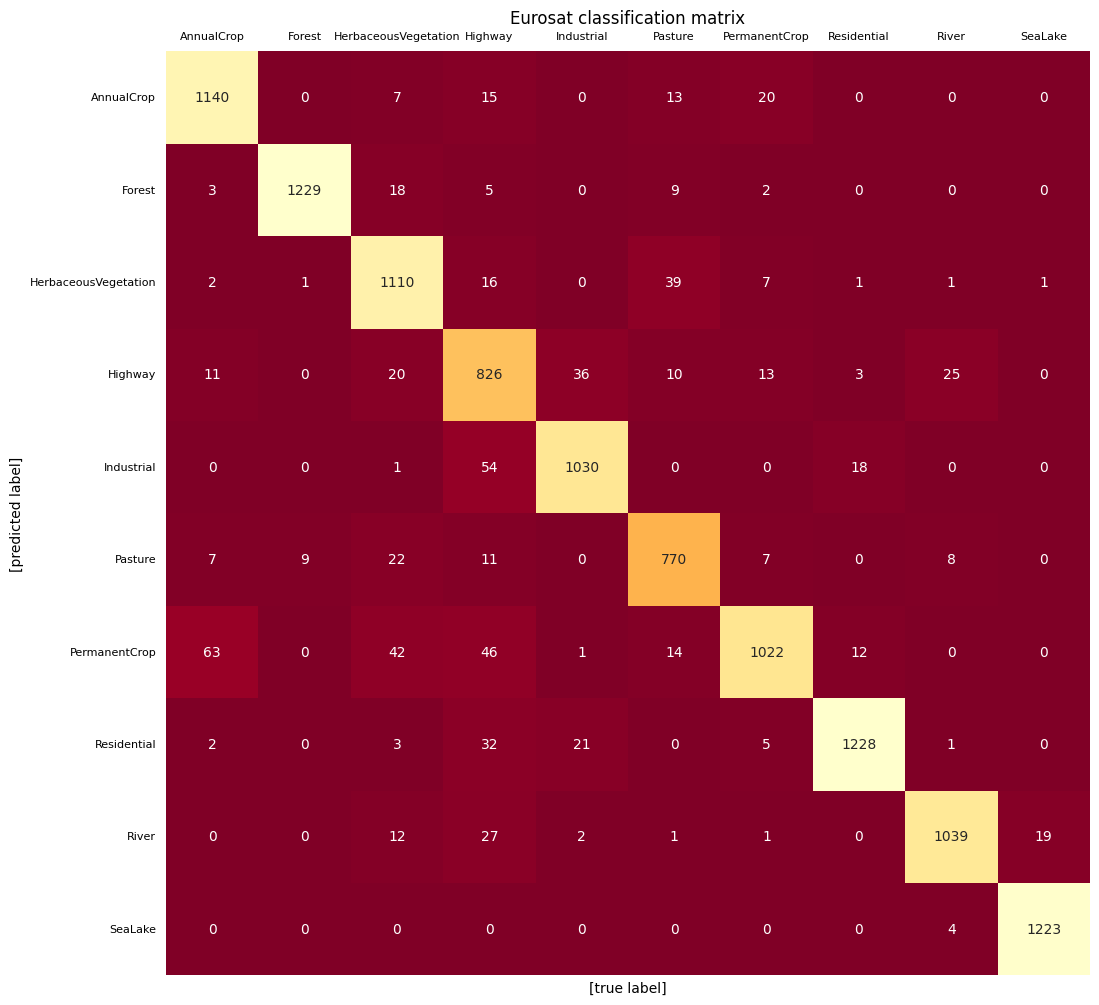

In [157]:
import seaborn as sns

# determine classification matrix of the predicted and target classes
mat = confusion_matrix(pred_labels, predictions)

# initialize the plot and define size
plt.figure(figsize=(12, 12))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=classes, yticklabels=classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('Eurosat classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

### **7.3 Model evaluation on official test data**

#### **7.3.1 Prepare official test data**
Two main steps:
1. Load all test samples
2. Add NDVI Index and normalize data to match our training data preparation steps

In [158]:
def create_testset(sample_paths):
  """Input: list of paths where samples are stored
  Loads all test samples, adds NDVI Index and normalizes data to match our training data preparation.
  Output: 4D array of test data images (NxHxWxC); 1D array of test labels"""

  test_data = []
  test_ids = []

  # loop through paths to load each test sample
  for i in range(len(sample_paths)):
    sample = sample_paths[i]
    number = sample.split('/')[-1].split('_')[1].split('.')[0]
    img = np.load(sample)

    #add NDMI index (B8A-B11)/(B8A+B11)
    index = np.array((img[:,:,8]-img[:,:,10])/(img[:,:,8]+img[:,:,10]))
    img = np.append(img, index.reshape(64,64,1), axis = 2)

    #add ND_custom(blue) index (B8-B2)/(B8+B2)
    index = np.array((img[:,:,7]-img[:,:,1])/(img[:,:,7]+img[:,:,1]))
    img = np.append(img, index.reshape(64,64,1), axis = 2)

    #add ND_custom(green) index (B8-B3)/(B8+B3)
    index = np.array((img[:,:,7]-img[:,:,2])/(img[:,:,7]+img[:,:,2]))
    img = np.append(img, index.reshape(64,64,1), axis = 2)

    #add NDVI index (B8-B4)/(B8+B4)
    index = np.array((img[:,:,7]-img[:,:,3])/(img[:,:,7]+img[:,:,3]))
    img = np.append(img, index.reshape(64,64,1), axis = 2)

    test_ids.append(number)
    test_data.append(np.array(img))

  test_data = np.array(test_data)
  test_data = normalize_data(test_data)
  test_data = np.moveaxis(test_data, 3, 1)
  test_ids = np.array(test_ids)
  return test_data, test_ids

In [159]:
#create official testset and transform it into a pytorch Tensor.
#error occurs due to NDVI index
official_test_data, official_test_id = create_testset(test_samples)
official_test_data_tensor = torch.from_numpy(np.array(official_test_data))

<ipython-input-158-3cc98c00eae8>:20: RuntimeWarning: invalid value encountered in divide
  index = np.array((img[:,:,7]-img[:,:,1])/(img[:,:,7]+img[:,:,1]))
<ipython-input-158-3cc98c00eae8>:24: RuntimeWarning: invalid value encountered in divide
  index = np.array((img[:,:,7]-img[:,:,2])/(img[:,:,7]+img[:,:,2]))
<ipython-input-158-3cc98c00eae8>:28: RuntimeWarning: invalid value encountered in divide
  index = np.array((img[:,:,7]-img[:,:,3])/(img[:,:,7]+img[:,:,3]))


In [160]:
print("Testset shape: " + str(official_test_data.shape))

Testset shape: (4232, 16, 64, 64)


In [161]:
# specifiy and instantiate PyTorch data loader that feeds the image tensors to our neural network
official_test_dataloader = torch.utils.data.DataLoader(official_test_data_tensor, batch_size=8, shuffle=False)

#### **7.3.2 Evaluate official test set**

In [162]:
# init collection of mini-batch losses
predictions = []

# iterate over all-mini batches
for i, images in enumerate(official_test_dataloader):

    # run forward pass through the network
    images = images.to(device, dtype = torch.float32)
    output = model(images)

    # collect predictons
    batch_predictions = torch.argmax(output, dim=1)

    # print log each 100 evaluation mini-batch
    if i % 100 == 0:

      # print mini-batch loss loss
      now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
      # multiply the number of mini-batches (i) by their size (8 images per mini-batch)
      print('[LOG {}] {} prediction(s) collected'.format(str(now), str(i*8)))

    # collect mini-batch reconstruction loss
    predictions.extend(batch_predictions.cpu().detach().numpy().tolist())
    # pred_labels.extend(labels.cpu().detach().numpy().tolist())

print('\nTotal predictions: {}'.format(len(predictions)))

[LOG 20240504-15:51:02] 0 prediction(s) collected
[LOG 20240504-15:51:03] 800 prediction(s) collected
[LOG 20240504-15:51:03] 1600 prediction(s) collected
[LOG 20240504-15:51:03] 2400 prediction(s) collected
[LOG 20240504-15:51:04] 3200 prediction(s) collected
[LOG 20240504-15:51:04] 4000 prediction(s) collected

Total predictions: 4232


#### **7.3.3 Transform output into Kaggle format**

In [163]:
import pandas as pd

def create_output(predictions, test_ids):
  """Input: list of predictions, list of test_ids.
  Links prediction list to test_id and creates a corresponding dataframe.
  Output: Pandas dataframe"""

  output = {}
  for i in range(len(predictions)):
    no = test_ids[i]
    output[no] = classes[predictions[i]]
  df = pd.DataFrame(output.items(), columns = ['test_id', 'label'])
  return df

In [164]:
result_df = create_output(predictions, official_test_id)

In [165]:
result_df.head(10)

,test_id,label
0,626,PermanentCrop
1,194,SeaLake
2,2744,Pasture
3,185,PermanentCrop
4,1726,PermanentCrop
5,934,Pasture
6,2566,SeaLake
7,2210,SeaLake
8,3954,PermanentCrop
9,667,SeaLake


In [166]:
#quick plausability check by looking at the distribution of classified labels
result_df.label.value_counts()

label
PermanentCrop           1567
SeaLake                 1004
Highway                  362
Pasture                  357
Residential              273
AnnualCrop               240
Industrial               235
River                    181
HerbaceousVegetation      13
Name: count, dtype: int64

In [167]:
# export to csv file
result_df.to_csv('schnitzel_bratwürst_classification.csv', index = False)